In [ ]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.colors as mcolors

In [ ]:
# Load data

crops = pd.read_csv('/content/drive/MyDrive/Preprocesses_data/preprocessed_700.csv')
crops.head()

,Name,Fertility,Photoperiod,N-P-K Ratio,Temperature,Rainfall,pH,Light_Hours,Light_Intensity,Rh,Nitrogen,Phosphorus,Potassium,Yield,Category_pH,Soil_Type,Season
0,Apple,High,Day Neutral,10:10:10,21.063204,1932.402709,6.567764,12.716549,860.189066,92.677579,89.266502,40.330099,180.635740,12.847482,low_acidic,Sandy Loam,Fall
1,Apple,High,Day Neutral,10:10:10,19.511305,1589.295994,6.784538,13.544560,797.660760,92.293923,92.808150,37.131922,179.042979,13.894292,neutral,Sandy Loam,Fall
2,Apple,High,Day Neutral,10:10:10,23.045662,1269.789133,6.619155,12.330668,910.861369,91.798926,84.248590,38.693498,163.604138,13.372204,low_acidic,Sandy Loam,Fall
3,Apple,High,Short Day Period,10:10:10,17.986016,1944.180144,6.638623,12.965340,922.725203,92.742710,84.780429,43.950592,173.881606,11.801568,neutral,Sandy Loam,Spring
4,Apple,High,Day Neutral,10:10:10,23.775354,1790.352815,6.654898,12.895817,821.411003,90.981530,91.197126,45.564470,174.324935,10.660521,neutral,Sandy Loam,Fall


In [ ]:
crops.isna().values.any()

False

In [ ]:
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23800 entries, 0 to 23799
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             23800 non-null  object 
 1   Fertility        23800 non-null  object 
 2   Photoperiod      23800 non-null  object 
 3   N-P-K Ratio      23800 non-null  object 
 4   Temperature      23800 non-null  float64
 5   Rainfall         23800 non-null  float64
 6   pH               23800 non-null  float64
 7   Light_Hours      23800 non-null  float64
 8   Light_Intensity  23800 non-null  float64
 9   Rh               23800 non-null  float64
 10  Nitrogen         23800 non-null  float64
 11  Phosphorus       23800 non-null  float64
 12  Potassium        23800 non-null  float64
 13  Yield            23800 non-null  float64
 14  Category_pH      23800 non-null  object 
 15  Soil_Type        23800 non-null  object 
 16  Season           23800 non-null  object 
dtypes: float64(1

In [ ]:
crops.describe()

,Temperature,Rainfall,pH,Light_Hours,Light_Intensity,Rh,Nitrogen,Phosphorus,Potassium,Yield
count,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000,23800.000000
mean,21.978474,1048.775960,6.238701,10.708792,428.144454,75.633995,143.077870,97.729048,178.380374,17.792950
std,4.382708,372.439104,0.836081,2.705223,210.594866,19.199301,60.180291,69.558537,90.676584,14.503704
min,9.355908,409.927161,2.940351,5.044913,66.000791,29.877266,40.077805,13.155191,34.982329,0.770213
25%,18.802279,756.618244,6.029328,7.479604,261.001150,55.986653,107.077056,47.208312,117.856142,6.309919
50%,21.424851,995.841172,6.431525,12.016017,403.601654,87.133888,140.252517,70.558185,174.455784,15.916217
75%,24.725214,1204.581048,6.691918,13.026169,573.610828,92.460093,163.848126,129.055964,223.645110,23.618085
max,39.913892,2786.343754,8.219020,16.721979,1028.679529,99.927439,409.639573,360.043619,579.953931,66.619242


In [ ]:
# Produce the target and the Features.

target = crops.Yield
Features = crops.drop('Yield', axis=1)

In [ ]:
# Separate Categorical Columns from Numerical

cat_columns = Features.select_dtypes(include='O').columns
num_columns = Features.select_dtypes(include=[int, float]).columns

In [ ]:
# Split the Dataset into train and Test to have out-sample and in-sample

X_train, X_test, y_train, y_test = train_test_split(Features, target, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Processing Categorical and Numerical Columns


## Preprocessing steps for categorical and numerical data
cat_step = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
num_step = [('standardscaler', StandardScaler())]

## Preprocessing pipeleines for categorical and numerical data
categorical_pipeline = Pipeline(steps=cat_step)
numerical_pipeline = Pipeline(steps=num_step)

## preprocessing transformers for bundled categorical and numerical data
transformers = [
    ('cat', categorical_pipeline, cat_columns),
    ('num', numerical_pipeline, num_columns)
    ]
## preprocessing transformers for bundled categorical and numerical data
preprocessor = ColumnTransformer(transformers=transformers)

## Transformed Data
transformed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
transformed_X_test = pd.DataFrame(preprocessor.transform(X_test))

## format Transformed Data column from integer to string
transformed_data_col = []
for values in transformed_X_train.columns.values:
  transformed_data_col.append(str(values))

transformed_X_train.set_axis(transformed_data_col, axis=1)
transformed_X_test.set_axis(transformed_data_col, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.767182,0.147649,0.084054,0.270330,-0.717268,0.882110,-0.256830,-0.523663,0.743255
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.490793,-0.134800,-0.235230,0.806044,-0.794788,0.840656,0.531843,-1.002261,0.520783
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.093989,-1.338353,-0.381253,-1.195290,0.610058,-1.108872,-0.083809,0.928673,1.311575
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.494860,1.445094,-0.741244,0.824082,1.003797,0.592647,0.325209,-0.486226,0.322295
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.455103,-0.048381,-0.451185,0.938652,-0.905341,0.877845,0.766178,-0.876730,0.549843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.559212,0.444051,1.356895,1.003383,-0.854149,-1.195066,-1.467473,0.445554,-0.143833
4756,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.871281,-1.116255,1.363955,0.193742,-0.829481,-2.147126,0.346947,3.255143,-0.197552
4757,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.687227,-0.884215,0.118604,-1.287199,-0.016107,-1.078558,-0.649789,0.040925,-0.193050
4758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.718537,-0.793740,-2.851344,0.206685,1.594082,0.837336,-0.974692,-0.836239,-0.113907


In [ ]:
# Develop Base Model.
base_model = RandomForestRegressor(random_state=42)
base_model.fit(transformed_X_train, y_train)

# predictions
base_model_predictions_X_train = base_model.predict(transformed_X_train)
base_model_predictions_X_test = base_model.predict(transformed_X_test)

In [ ]:
# Find the lost function

mae_X_train = mean_absolute_error(y_train, base_model_predictions_X_train) * 100
mae_X_test = mean_absolute_error(y_test, base_model_predictions_X_test) * 100


print(f'Mean Square Error X_train: \t{mae_X_train:.2f}% \nMean Square Error X_test: \t{mae_X_test:.2f}%')

Mean Square Error X_train: 	23.04% 
Mean Square Error X_test: 	62.55%


## Feature Engineering

In [ ]:
# Create a copy of crop dataSet

crop_update = crops.copy()

In [ ]:
# Seperation of the NPK Ratio

crop_update[['N Ratio', 'P Ratio', 'K Ratio']] = crop_update['N-P-K Ratio'].str.split(':', expand=True)

crop_update['N Ratio'] = pd.to_numeric(crop_update['N Ratio'])
crop_update['P Ratio'] = pd.to_numeric(crop_update['P Ratio'])
crop_update['K Ratio'] = pd.to_numeric(crop_update['K Ratio'])

In [ ]:
# Calculate the Nutrient Uptake for independent Nutrient, The derivative is given by Yield Multiply Nutrient content divide by 100

crop_update.insert(13, column='N Nutrient Uptake', value=(crop_update.Yield.values * crop_update.Nitrogen.values) / 100)
crop_update.insert(14, column='P Nutrient Uptake', value=(crop_update.Yield.values * crop_update.Potassium.values) / 100)
crop_update.insert(15, column='K Nutrient Uptake', value=(crop_update.Yield.values * crop_update.Phosphorus.values) / 100)

In [ ]:
# Water Nutrient Intaraction values with NPK is given by Rainfall multiply by the sum of NPK

WN = crop_update.Rainfall * (crop_update.Nitrogen + crop_update.Phosphorus + crop_update.Potassium)
crop_update.insert(16, column='Water Nutrient', value=WN)

In [ ]:
# Additional pH required currentis the changes in pH and optimal pH

optimum_pH = crop_update.pH.max()
crop_update.insert(7, column='pH Defeciecy', value=optimum_pH - crop_update.pH)

In [ ]:
# Additional pH required currentis the changes in pH and optimal pH

optimum_potassium = crop_update.Potassium.max()
optimum_Phosphorus = crop_update.Phosphorus.max()
optimum_Nitrogen = crop_update.Nitrogen.max()

crop_update.insert(12, column='Nitrogen Defeciecy', value=optimum_pH - crop_update.pH)
crop_update.insert(14, column='Potassium Defeciecy', value=optimum_pH - crop_update.pH)
crop_update.insert(13, column='Phosphorus Defeciecy', value=optimum_pH - crop_update.pH)

In [ ]:
# Total Nutrient Available

Total_Avail_Nutrient = crop_update.Nitrogen + crop_update.Potassium + crop_update.Phosphorus
crop_update.insert(22, column='Total Avail Nutrient', value=Total_Avail_Nutrient)

In [ ]:
# Ratio of Individual Nutrients

crop_update.insert(23, column='Avail Ratio Of Nitrogen', value=crop_update.Nitrogen / crop_update['Total Avail Nutrient'] * 10)
crop_update.insert(24, column='Avail Ratio Of Potassium', value=crop_update.Potassium / crop_update['Total Avail Nutrient'] * 10)
crop_update.insert(25, column='Avail Ratio Of Phosphorus', value=crop_update.Phosphorus / crop_update['Total Avail Nutrient'] * 10)

In [ ]:
# Defficiency of Avail Ratio Of Nutrients

crop_update['N Defficient Ratio'] = crop_update['N Ratio'].subtract(crop_update['Avail Ratio Of Nitrogen'])
crop_update['P Defficient Ratio'] = crop_update['P Ratio'].subtract(crop_update['Avail Ratio Of Potassium'])
crop_update['K Defficient Ratio'] = crop_update['K Ratio'].subtract(crop_update['Avail Ratio Of Phosphorus'])

In [ ]:
# Categorize the crops into Types (grouped the crops)

fruits_500 = pd.read_csv('/content/drive/MyDrive/Final_Synthetic_Data/Fruits/synthetic_fruits_normal_crop_data_500.csv')
salads_500 = pd.read_csv('/content/drive/MyDrive/Final_Synthetic_Data/Salads/synthetic_salads_normal_crop_data_500.csv')
vegetables_500 = pd.read_csv('/content/drive/MyDrive/Final_Synthetic_Data/Vegetables/synthetic_veg_normal_crop_data_500.csv')

vegetables = crop_update.Name.isin(vegetables_500.Name)
fruits = crop_update.Name.isin(fruits_500.Name)
salads = crop_update.Name.isin(salads_500.Name)

crop_update.insert(1, column='Crop Type', value=crop_update.Name.where(vegetables, "Vegetable").where(fruits, "Fruit").where(salads, "Salads"))

In [ ]:
# Up of date Numerical Columns data bank

updates_num_col = [col_name for col_name in crop_update.columns if crop_update[col_name].dtype != 'O']

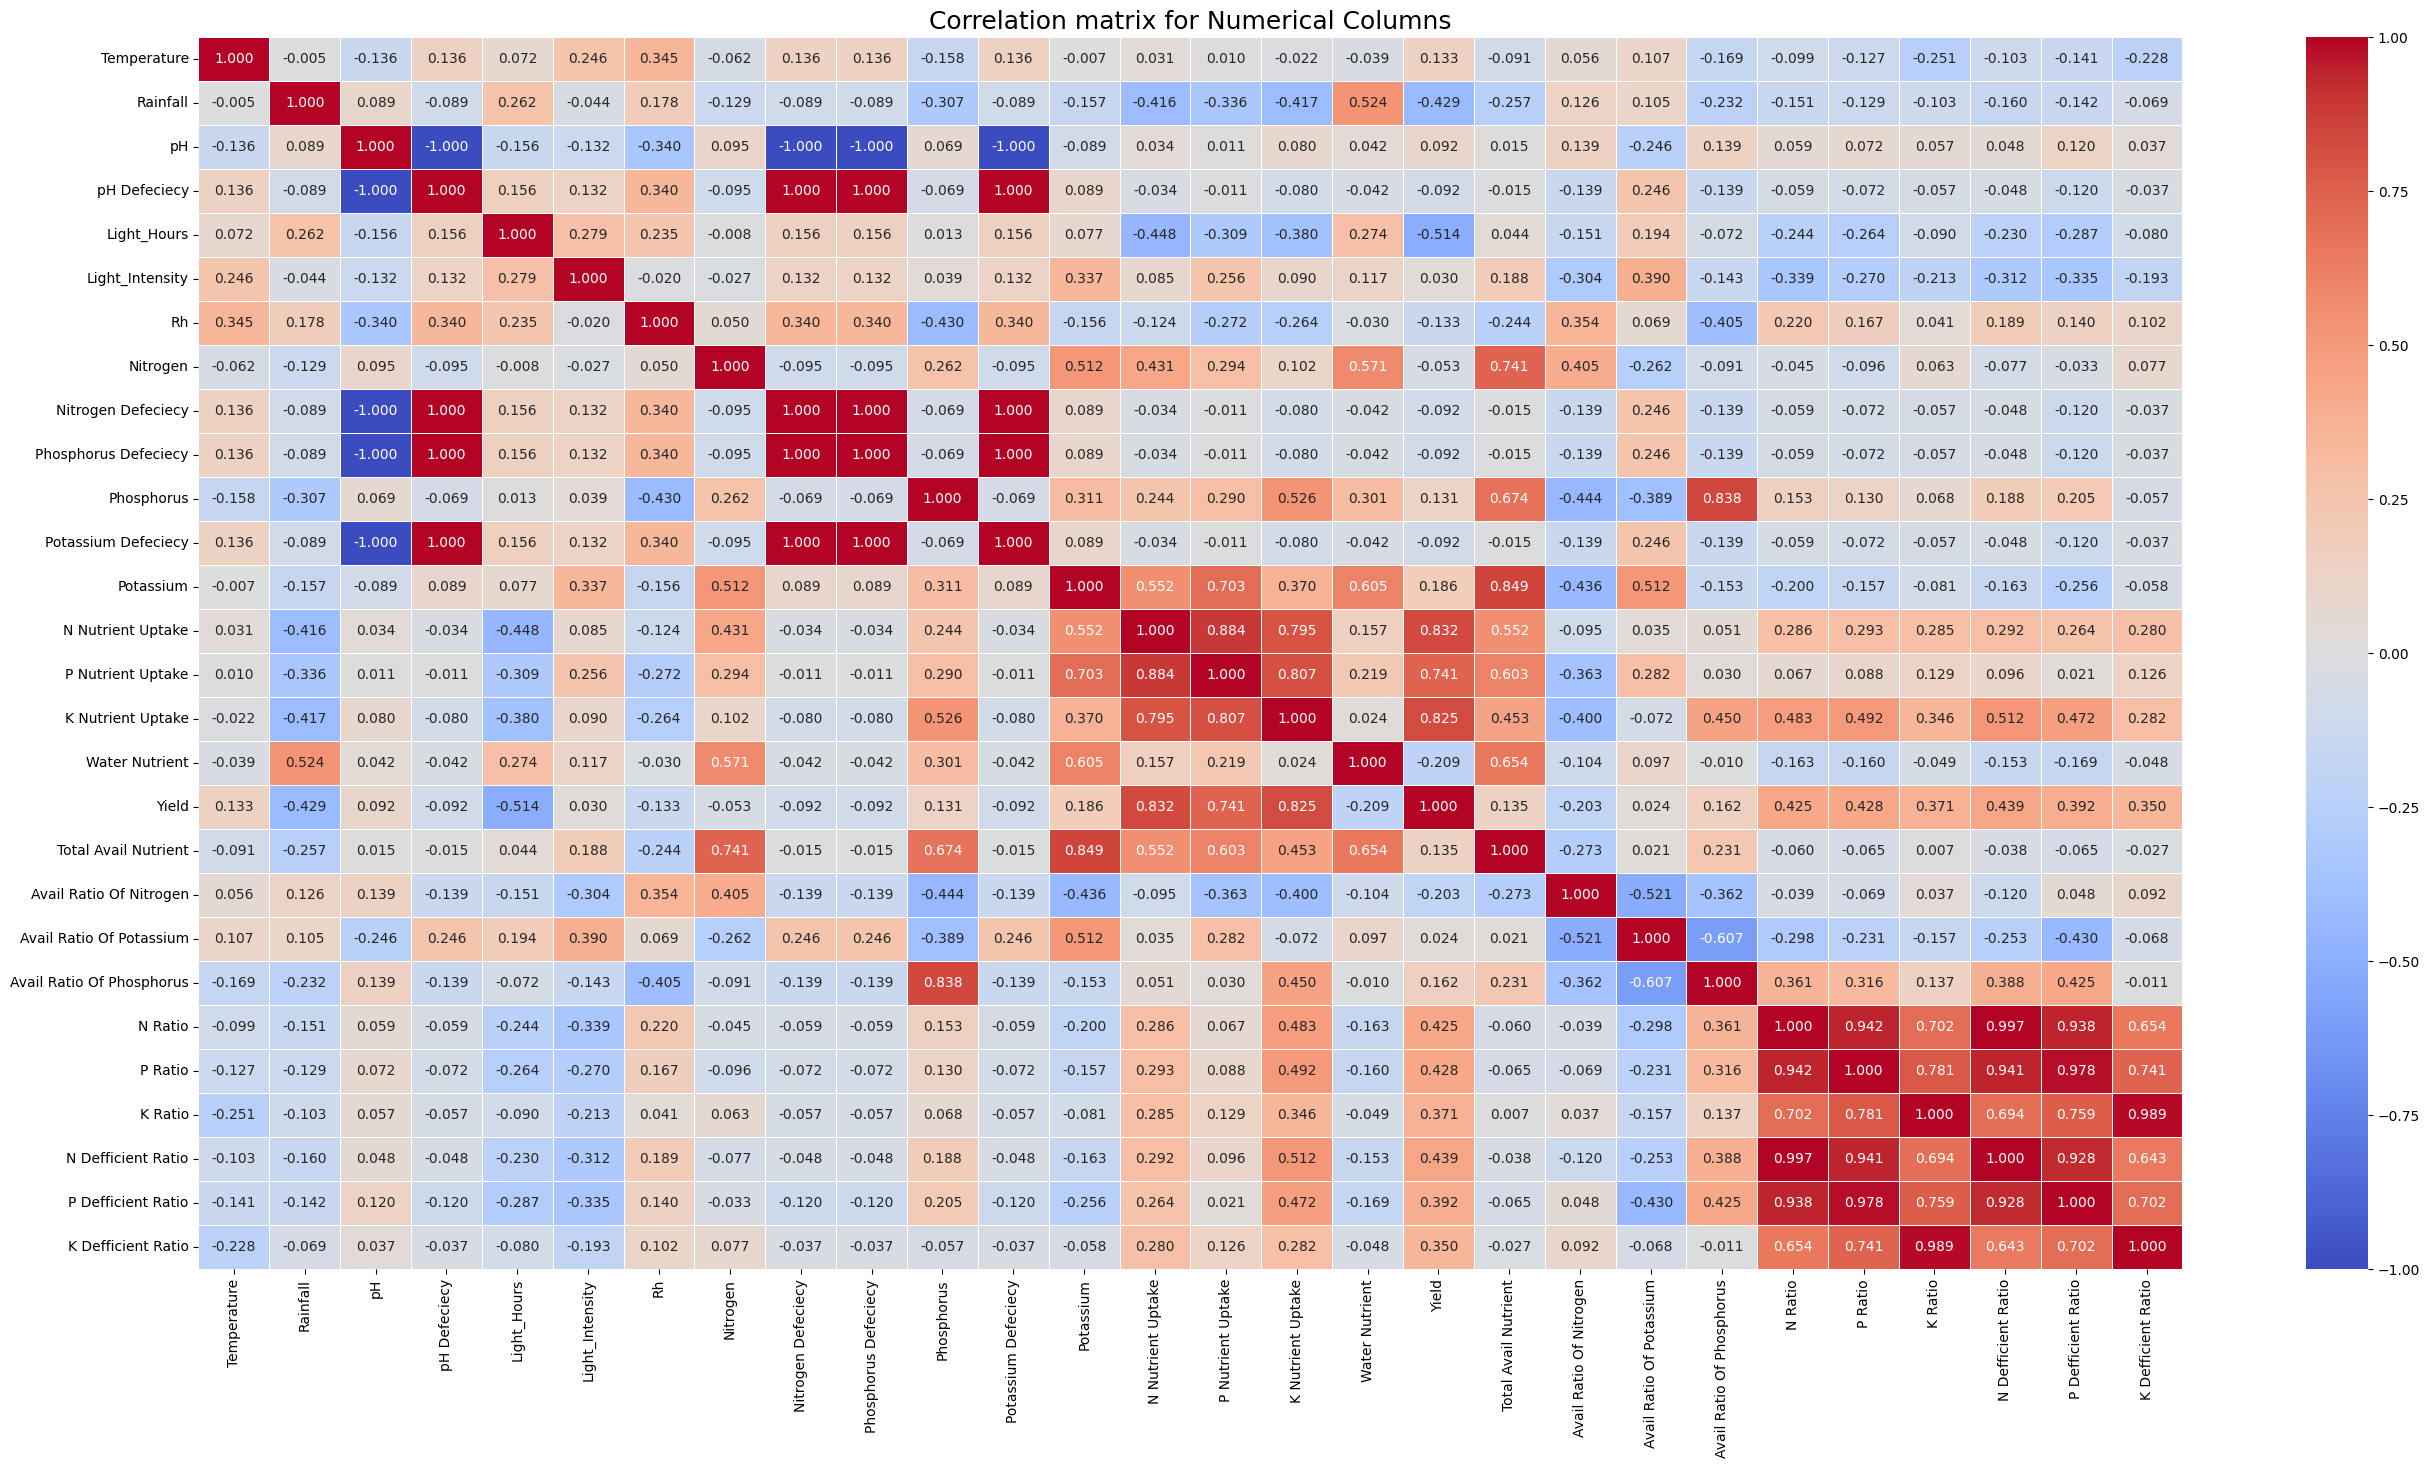

In [ ]:
# Find the Correlation matrix updated Numerical Columns

crop_update_corr = crop_update[updates_num_col].corr()

plt.figure(figsize=(32, 16))
sns.heatmap(crop_update_corr, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.title('Correlation matrix for Numerical Columns', fontsize=18)
plt.show()

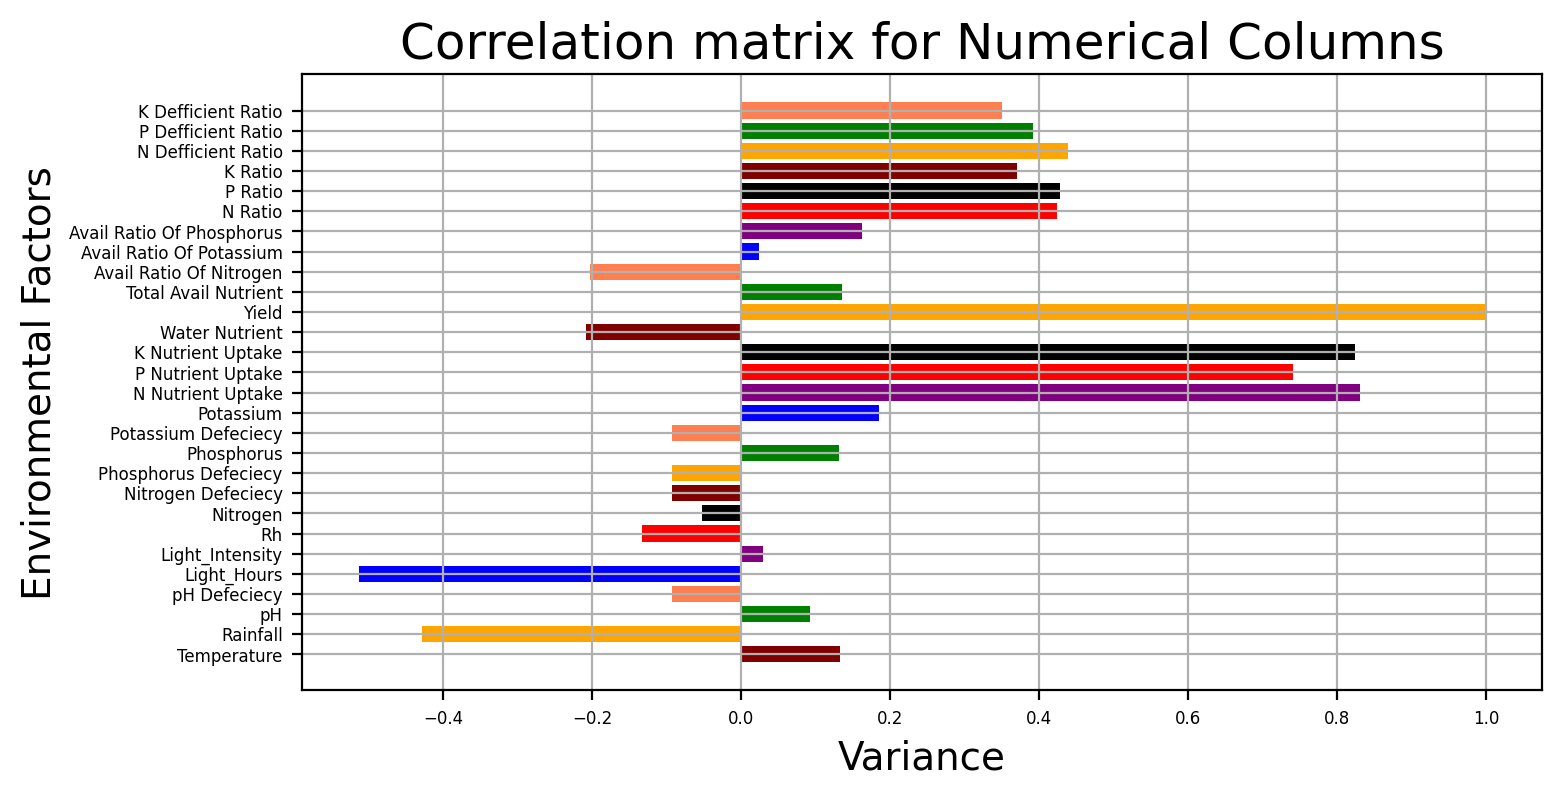

In [ ]:
# creating the bar plot of Correlation matrix updated Numerical Columns
plt.figure(figsize=(8, 4), dpi=200, edgecolor='b')
plt.grid('grey')
plt.barh(crop_update_corr.index, crop_update_corr.Yield, color=['maroon', 'orange', 'green', 'coral', 'blue', 'purple', 'red', 'black'])
plt.xlabel("Variance", fontsize=14)
plt.ylabel("Environmental Factors", fontsize=14)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
plt.title("Correlation matrix for Numerical Columns", fontsize=18)

plt.show()

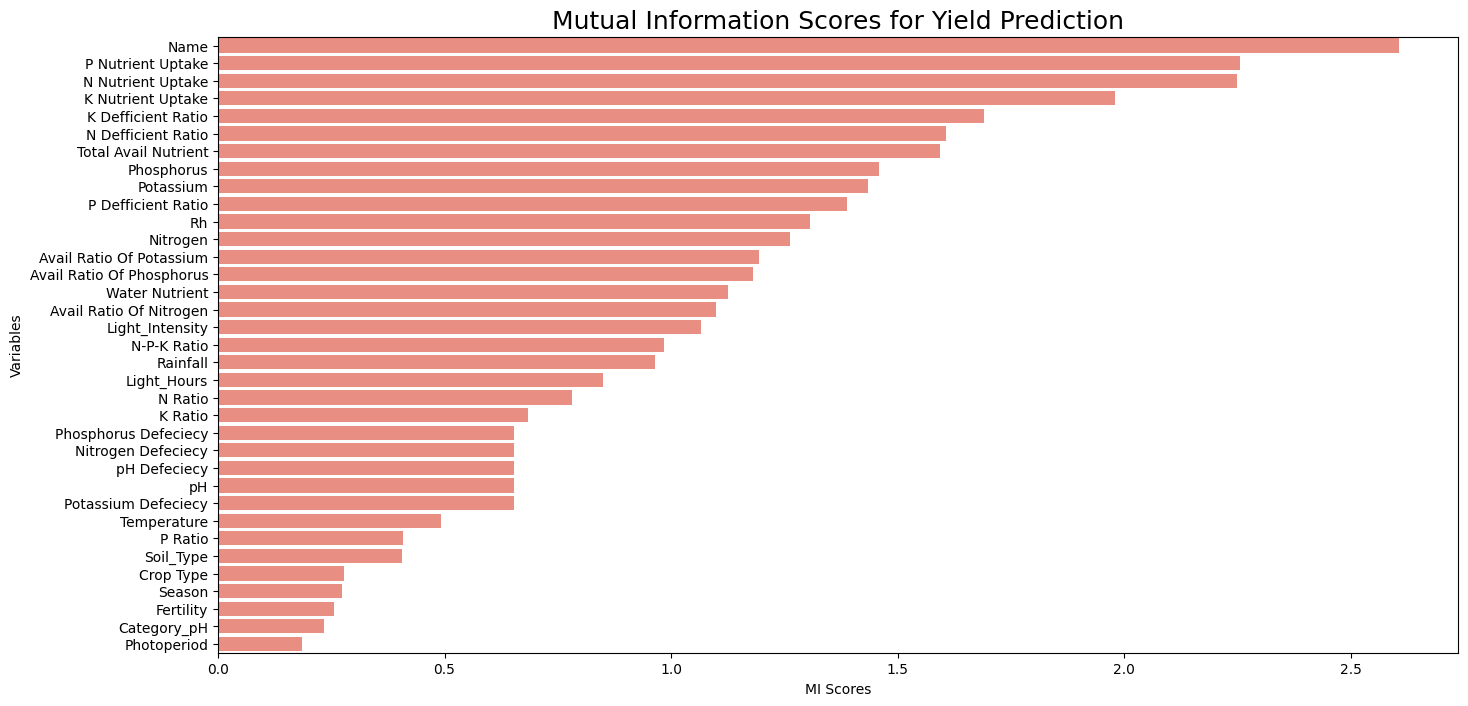

In [ ]:
# Preparing Data for Mututal info

from sklearn.feature_selection import mutual_info_regression

crop_update_mi = crop_update.copy()

y = crop_update_mi.pop('Yield')
X = crop_update_mi

for colname in X.columns:
  if X[colname].dtypes == 'O':
    X[colname], _= X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = pd.DataFrame(make_mi_scores(X, y, discrete_features)).reset_index().rename(columns={'index':'Variables'})


def plot_mi_scores(scores, x, y):
    plt.figure(dpi=100, figsize=(16, 8))
    sns.barplot(x=x, y=y, orient='h', color = "salmon")
    plt.title("Mutual Information Scores for Yield Prediction", fontsize=18)



plot_mi_scores(mi_scores,  mi_scores['MI Scores'], mi_scores['Variables'])

In [ ]:
# Removing high correlated Duplicate Features.

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(crop_update_corr.drop("Yield", axis=1), 0.9)
len(set(corr_features))

10

In [ ]:
feature_selected = crop_update.drop(corr_features, axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(crop_update[feature_selected], target, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
cat_columns = X_train.select_dtypes(include='O').columns
num_columns = X_train.select_dtypes(include=[int, float]).columns

In [ ]:
# Processing Categorical and Numerical Columns


## Preprocessing steps for categorical and numerical data
cat_step = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
num_step = [('standardscaler', StandardScaler())]

## Preprocessing pipeleines for categorical and numerical data
categorical_pipeline = Pipeline(steps=cat_step)
numerical_pipeline = Pipeline(steps=num_step)

## preprocessing transformers for bundled categorical and numerical data
transformers = [
    ('cat', categorical_pipeline, cat_columns),
    ('num', numerical_pipeline, num_columns)
    ]
## preprocessing transformers for bundled categorical and numerical data
preprocessor = ColumnTransformer(transformers=transformers)

## Transformed Data
transformed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
transformed_X_test = pd.DataFrame(preprocessor.transform(X_test))

## format Transformed Data column from integer to string
transformed_data_col = []
for values in transformed_X_train.columns.values:
  transformed_data_col.append(str(values))

transformed_X_train.set_axis(transformed_data_col, axis=1)
transformed_X_test.set_axis(transformed_data_col, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.743255,-0.615077,-0.574351,0.307802,-0.613905,0.090622,-0.609704,1.263690,-0.809684,-0.568506
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.520783,-0.397195,-0.698185,0.021660,-0.588743,0.053777,0.597530,0.915325,-1.552709,-0.136861
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.311575,2.617539,3.426882,-0.530158,2.916232,1.061228,-1.271368,0.651067,0.472909,-0.136861
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.322295,0.181219,-0.316004,1.462078,0.003088,0.087543,0.240709,0.482229,-0.749133,-0.136861
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.549843,-0.456615,-0.685179,0.241493,-0.684020,0.205203,0.682446,0.702342,-1.399651,-0.136861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.143833,-0.657262,0.242746,0.005195,0.073124,-0.416260,-2.043151,0.439127,1.421408,0.899086
4756,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.197552,-0.592029,0.206583,-0.078411,-0.727313,1.369436,-1.046525,-1.591971,2.707300,-0.136861
4757,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.193050,-0.025778,0.212191,-0.884355,0.388473,-0.318836,-0.706042,0.139679,0.504335,-0.136861
4758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.113907,-0.629123,-0.587167,-1.119240,-0.328839,-0.756542,-0.653568,1.353662,-0.866909,-0.136861


In [ ]:
# Develop  Model.
model = RandomForestRegressor(random_state=42, n_estimators=500)
model.fit(transformed_X_train, y_train)

# predictions
model_predictions_X_train = model.predict(transformed_X_train)
model_predictions_X_test = model.predict(transformed_X_test)

In [ ]:

# Find the lost function

mae_X_train = mean_absolute_error(y_train, model_predictions_X_train)
mae_X_test = mean_absolute_error(y_test, model_predictions_X_test)


print(f'Mean Square Error X_train: \t{mae_X_train:.4f} \nMean Square Error X_test: \t{mae_X_test:.4f}')

Mean Square Error X_train: 	0.0009 
Mean Square Error X_test: 	0.0026


## Parameter Tuning

In [ ]:
# def score(transformed_X_train, y_train, transformed_X_test, y_test, n_estimators):
#   # Develop Model.
#   model = RandomForestRegressor(random_state=42, n_estimators=n_estimators)
#   model.fit(transformed_X_train, y_train)

#   # predictions
#   model_predictions_X_train = model.predict(transformed_X_train)
#   model_predictions_X_test = model.predict(transformed_X_test)

#   # Mean Square Error
#   mae_X_train = mean_absolute_error(y_train, model_predictions_X_train) * 100
#   mae_X_test = mean_absolute_error(y_test, model_predictions_X_test) * 100

#   return mae_X_train


In [ ]:
# score = {n_estimators: score(transformed_X_train, y_train, transformed_X_test, y_test, n_estimators) for n_estimators in range(100, 5001, 100)}

In [ ]:
# score

<function __main__.score(transformed_X_train, y_train, transformed_X_test, y_test, n_estimators)>

In [ ]:
# result = pd.DataFrame(score, index=np.arange(len(score) - 1), )
# result = result.pivot(columns=, index=result.columns)
# import plotly.express as px


# fig = px.bar(data_frame=score, y=score['scores'], x=score['n_estimators'], color=score['n_estimators'])
# fig.show()

# Final Model

In [ ]:
# # Develop Model.
# final_model = RandomForestRegressor(random_state=42, n_estimators=450)
# final_model.fit(transformed_X_train, y_train)

# # predictions
# final_predictions_X_train = final_model.predict(transformed_X_train)
# final_predictions_X_test = final_model.predict(transformed_X_test)

# # Mean Square Error
# mae_X_train = mean_absolute_error(y_train, final_predictions_X_train)
# mae_X_test = mean_absolute_error(y_test, final_predictions_X_test)


In [ ]:
# print(f'Mean Square Error X_train:\t{mae_X_train:.4f} \nMean Square Error X_test:\t{mae_X_test:.4f}')

# **Crop Selction**

## Mutual Information for crop seclection

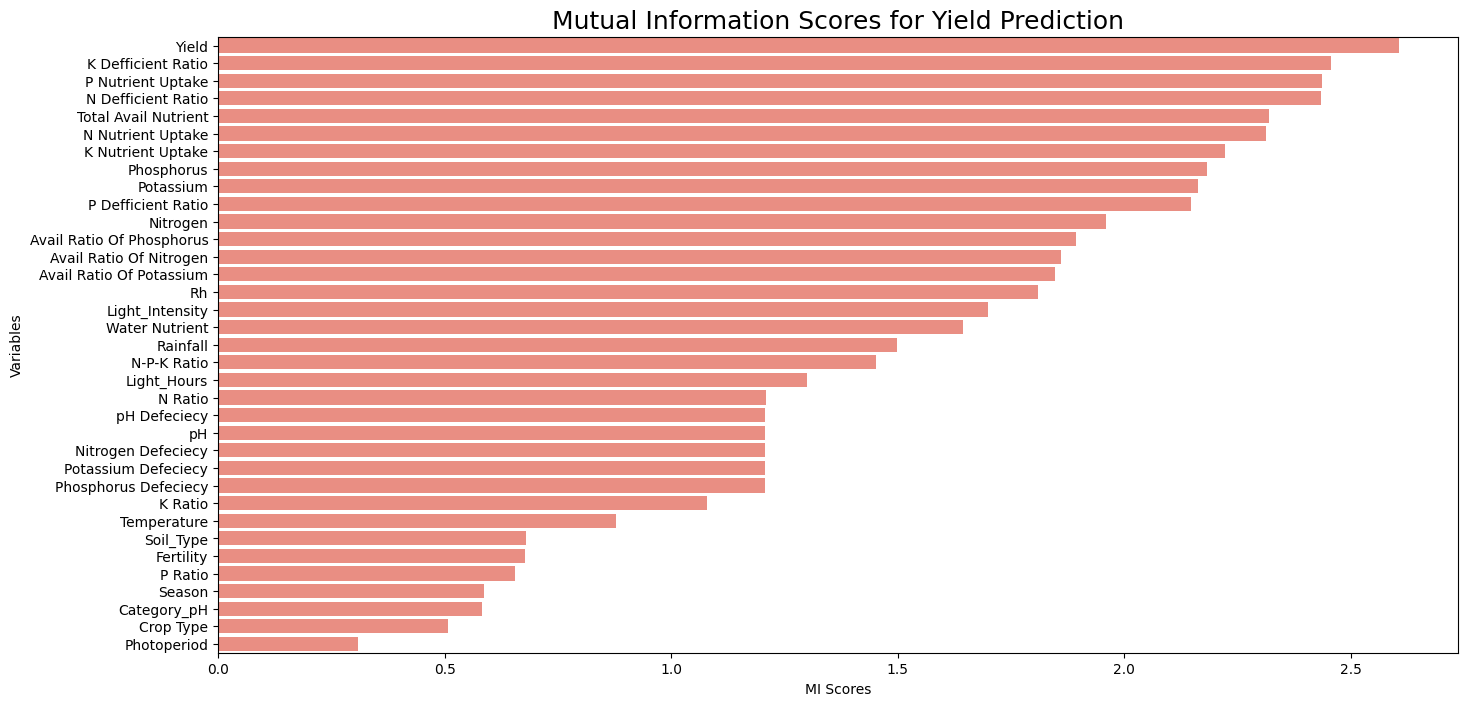

In [ ]:
# Preparing Data for Mututal info

from sklearn.feature_selection import mutual_info_regression

crop_update_mi = crop_update.copy()

y, _ = crop_update_mi.pop('Name').factorize()
X = crop_update_mi

for colname in X.columns:
  if X[colname].dtypes == 'O':
    X[colname], _= X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = pd.DataFrame(make_mi_scores(X, y, discrete_features)).reset_index().rename(columns={'index':'Variables'})


def plot_mi_scores(scores, x, y):
    plt.figure(dpi=100, figsize=(16, 8))
    sns.barplot(x=x, y=y, orient='h', color = "salmon")
    plt.title("Mutual Information Scores for Yield Prediction", fontsize=18)



plot_mi_scores(mi_scores,  mi_scores['MI Scores'], mi_scores['Variables'])

In [ ]:
num_feature_selected = crop_update_corr.drop(corr_features, axis=1).columns
cat_features_selected = [value.Variables for row, value in mi_scores.iterrows() if value['MI Scores'] > 0.6 and value.Variables in crop_update.select_dtypes('O').columns]
feature_selected  = []

for col in cat_features_selected:
  feature_selected.append(col)


for col in num_feature_selected:
   feature_selected.append(col)


X_train, X_test, y_train, y_test = train_test_split(crop_update[feature_selected], y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
cat_columns = X_train.select_dtypes(include='O').columns
num_columns = X_train.select_dtypes(include=[int, float]).columns

In [ ]:

# Processing Categorical and Numerical Columns


## Preprocessing steps for categorical and numerical data
cat_step = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
num_step = [('standardscaler', StandardScaler())]

## Preprocessing pipeleines for categorical and numerical data
categorical_pipeline = Pipeline(steps=cat_step)
numerical_pipeline = Pipeline(steps=num_step)

## preprocessing transformers for bundled categorical and numerical data
transformers = [
    ('cat', categorical_pipeline, cat_columns),
    ('num', numerical_pipeline, num_columns)
    ]
## preprocessing transformers for bundled categorical and numerical data
preprocessor = ColumnTransformer(transformers=transformers)

## Transformed Data
transformed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
transformed_X_test = pd.DataFrame(preprocessor.transform(X_test))

## format Transformed Data column from integer to string
transformed_data_col = []
for values in transformed_X_train.columns.values:
  transformed_data_col.append(str(values))

transformed_X_train.set_axis(transformed_data_col, axis=1)
transformed_X_test.set_axis(transformed_data_col, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.743255,-0.615077,-0.574351,0.307802,-0.613905,0.090622,-0.609704,1.263690,-0.809684,-0.568506
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.520783,-0.397195,-0.698185,0.021660,-0.588743,0.053777,0.597530,0.915325,-1.552709,-0.136861
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.311575,2.617539,3.426882,-0.530158,2.916232,1.061228,-1.271368,0.651067,0.472909,-0.136861
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.322295,0.181219,-0.316004,1.462078,0.003088,0.087543,0.240709,0.482229,-0.749133,-0.136861
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.549843,-0.456615,-0.685179,0.241493,-0.684020,0.205203,0.682446,0.702342,-1.399651,-0.136861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.143833,-0.657262,0.242746,0.005195,0.073124,-0.416260,-2.043151,0.439127,1.421408,0.899086
4756,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.197552,-0.592029,0.206583,-0.078411,-0.727313,1.369436,-1.046525,-1.591971,2.707300,-0.136861
4757,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.193050,-0.025778,0.212191,-0.884355,0.388473,-0.318836,-0.706042,0.139679,0.504335,-0.136861
4758,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.113907,-0.629123,-0.587167,-1.119240,-0.328839,-0.756542,-0.653568,1.353662,-0.866909,-0.136861


In [ ]:
# Develop  Model.
model_classifier = RandomForestClassifier(random_state=42)
model_classifier.fit(transformed_X_train, y_train)

# predictions
model_classifier_predictions_X_train = model_classifier.predict(transformed_X_train)
model_classifier_predictions_X_test = model_classifier.predict(transformed_X_test)

In [ ]:
# Find the lost function

as_X_train = accuracy_score(y_train, model_classifier_predictions_X_train)
as_X_test = accuracy_score(y_test, model_classifier_predictions_X_test)


print(f'Accuracy Score X_train:\t{as_X_train:.4f} \nAccuracy Score X_test:\t{as_X_test:.4f}')

Accuracy Score X_train:	1.0000 
Accuracy Score X_test:	1.0000
